In [1]:
import argparse
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from models.conv_lstm import ConvLSTM_Model
from models.sa_conv_lstm import SA_ConvLSTM_Model
import numpy as np 
import os
import io
import imageio
from ipywidgets import widgets, HBox
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from utils.dataloader import MovingMNIST_Test

parser = argparse.ArgumentParser()
parser.add_argument('--lr', default=1e-4, type=float, help='learning rate')
parser.add_argument('--batch_size', default=1, type=int, help='batch size')
parser.add_argument('--epochs', type=int, default=1, help='number of epochs to train for')
parser.add_argument('--n_gpus', type=int, default=1, help='number of GPUs')
parser.add_argument('--hidden_dim', type=int, default=64, help='number of hidden dim for ConvLSTM layers')
parser.add_argument('--input_dim', type=int, default=1, help='input channels')
parser.add_argument('--model', type=str, default='convlstm', help='model to train')
parser.add_argument('--frame_num', type=int, default=10, help='number of frames')
parser.add_argument('--img_size', type=int, default=64, help='image size')
parser.add_argument('--gpu_id', type=int, default=0, help='GPU ID')
parser.add_argument('--num_layers', type=int, default=2, help='number of layers')
args = parser.parse_args([])

def load_checkpoint(model, args, path):
    checkpoint = torch.load(path, map_location='cpu')
    parameters = checkpoint['model_state_dict']
    start_epoch = checkpoint['epoch']+1
    optimizer_state_dict = checkpoint['optimizer_state_dict']
    args.lr = checkpoint['lr']
    
    weights = {}
    for name, value in zip(model.state_dict().keys(), parameters.values()):
        weights[name] = value
    model.load_state_dict(weights)
    
    torch.cuda.empty_cache()
    
    return start_epoch, args.lr, optimizer_state_dict

N_STEPS = 10

# path for the datasets
path = "/data2/jjlee_datasets/MovingMNIST/"
args.gpu_num = 1
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()

def load_data(path):
    # path for the datasets
    data_path = path
    
    test_data =  MovingMNIST_Test(path=data_path, n_frames_input=N_STEPS, n_frames_output=N_STEPS)
    return test_data

In [25]:
test_data = load_data(path)
test_loader = DataLoader(test_data, shuffle=True, batch_size=args.batch_size)#, collate_fn=collate_test)
convlstm = ConvLSTM_Model(args)
sa_convlstm = SA_ConvLSTM_Model(args)

# for key, param in convlstm.state_dict().items():
#     print(key)

sa_path = f'./model_ckpt/sa_convlstm_layer{args.num_layers}_best_model.pth'
conv_path = f'./model_ckpt/convlstm_layer{args.num_layers}_best_model.pth'

# load_checkpoint(sa_convlstm, args, sa_path)
load_checkpoint(convlstm, args, conv_path)

convlstm.cuda().eval()
# sa_convlstm.cuda().eval()


# Sample a batch
inputs, targets = next(iter(test_loader))
inputs = inputs.cuda()


batch = torch.cat([inputs, targets.cuda()], dim=1).cuda()
# sa_convlstm_out = sa_convlstm(batch).cpu().detach()
# convlstm_out = convlstm(inputs).cpu().detach()

# output_sa_convlstm = (sa_convlstm_out.squeeze(2).cpu().detach().numpy()* 255.0).astype(np.uint8)
# output_convlstm = (convlstm_out.squeeze(2).cpu().detach().numpy() * 255.0).astype(np.uint8)

targets = (inputs.squeeze(2).cpu().detach().numpy()*255.0).astype(np.uint8)

output_convlstm = np.zeros((args.batch_size, args.frame_num, args.img_size, args.img_size)).astype(np.uint8)
output_sa_convlstm = np.zeros((args.batch_size, args.frame_num, args.img_size, args.img_size)).astype(np.uint8)

for i in range(args.frame_num):
    inputs = batch[:, i:i+args.frame_num, :, :, :]
    output_convlstm[:, i,:] = convlstm(inputs)[:, 0, :,:].cpu().detach().numpy() * 255.0
    
for i in range(args.frame_num):
    inputs = batch[:, i:i+args.frame_num, :, :, :]
    output_sa_convlstm[:, i,:] = sa_convlstm(inputs)[:, 0, :,:].cpu().detach().numpy() * 255.0



(1, 10, 64, 64)
(1, 10, 64, 64)


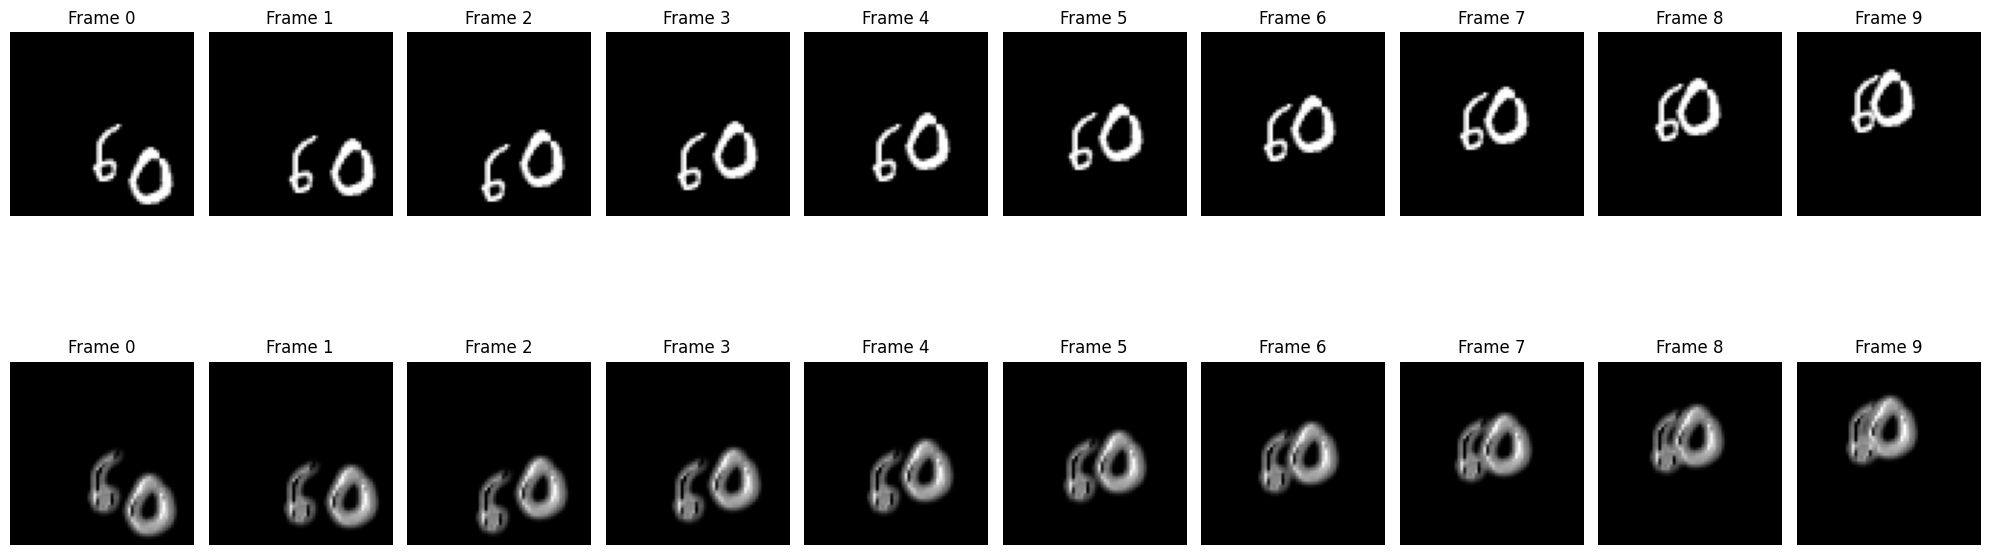

MSE:11.5692 
MAE:27.1437 
ConvLSTM SSIM:0.6144


In [26]:
for target, output in zip(targets, output_convlstm):

    num_images_tgt = len(target)
    num_images_out = len(output)
    
    fig, axes = plt.subplots(2, max(num_images_tgt, num_images_out), figsize=(20, 8))

    for idx, img in enumerate(target):
        axes[0, idx].imshow(img, cmap='gray')
        axes[0, idx].set_title(f"Frame {idx}")
        axes[0, idx].axis('off')
        globals()['img{}'.format(idx)] = img

    # Plot each image in 'out' on the second row
    for idx, img in enumerate(output):
        axes[1, idx].imshow(img, cmap='gray')
        axes[1, idx].set_title(f"Frame {idx}")
        axes[1, idx].axis('off')
        globals()['img{}'.format(idx+10)] = img

    for idx in range(num_images_tgt, max(num_images_tgt, num_images_out)):
        axes[0, idx].axis('off')
    for idx in range(num_images_out, max(num_images_tgt, num_images_out)):
        axes[1, idx].axis('off')

    plt.tight_layout()
    plt.show()

mse_total = 0.
mae_total = 0.
ssim_value=0.


for tgt, out in zip(targets, output_convlstm):
    mse = np.mean((tgt-out)**2)
    mse_total += mse/len(targets)
print("MSE:{:.4f} ".format(mse_total))


for tgt, out in zip(targets, output_convlstm):
    mae = np.mean(np.abs(tgt-out))
    mae_total += mae/len(targets)
print("MAE:{:.4f} ".format(mae_total))
    
for tgt, out in zip(targets, output_convlstm):
    ssim_value += ssim(tgt, out)/len(targets)
print("ConvLSTM SSIM:{:.4f}".format(ssim_value))

    
for target, output in zip(targets, output_convlstm):

    with io.BytesIO() as gif:
        imageio.mimsave(gif, target, "GIF", duration = 10)
        target_gif = gif.getvalue()
    with io.BytesIO() as gif:
        imageio.mimsave(gif, output, "GIF", duration = 10)
        output_gif = gif.getvalue()
        
    display(HBox([widgets.Image(value=target_gif),
                    widgets.Image(value=output_gif)]))

In [ ]:
for target, output in zip(targets, output_sa_convlstm):

    num_images_tgt = len(target)
    num_images_out = len(output)

    fig, axes = plt.subplots(2, max(num_images_tgt, num_images_out), figsize=(20, 8))

    for idx, img in enumerate(target):
        axes[0, idx].imshow(img, cmap='gray')
        axes[0, idx].set_title(f"Tgt Frame {idx}")
        axes[0, idx].axis('off')
        globals()['img{}'.format(idx)] = img

    # Plot each image in 'out' on the second row
    for idx, img in enumerate(output):
        axes[1, idx].imshow(img, cmap='gray')
        axes[1, idx].set_title(f"Out Frame {idx}")
        axes[1, idx].axis('off')
        globals()['img{}'.format(idx+10)] = img

    for idx in range(num_images_tgt, max(num_images_tgt, num_images_out)):
        axes[0, idx].axis('off')
    for idx in range(num_images_out, max(num_images_tgt, num_images_out)):
        axes[1, idx].axis('off')

    plt.tight_layout()
    plt.show()
    

mse_total = 0.
mae_total = 0.
ssim_value=0.

for tgt, out in zip(targets, output_sa_convlstm):
    mse = np.mean((tgt-out)**2)
    mse_total += mse/len(targets)
print("MSE:{:.4f} ".format(mse_total))

for tgt, out in zip(targets, output_sa_convlstm):
    mae = np.mean(np.abs(tgt-out))
    mae_total += mae/len(targets)
print("MAE:{:.4f} ".format(mae_total))
    
for tgt, out in zip(targets, output_sa_convlstm):
    ssim_value += ssim(tgt, out)/len(targets)
print("SA ConvLSTM SSIM:{:.4f}".format(ssim_value))

    

for target, output in zip(targets, output_sa_convlstm):

    # Write target video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, target, "GIF", duration = 10)
        target_gif = gif.getvalue()

    # Write output video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, output, "GIF", duration = 10)
        output_gif = gif.getvalue()

    display(HBox([widgets.Image(value=target_gif),
                    widgets.Image(value=output_gif)]))